Importamos las dependencias

In [70]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Cargamos desde el repositorio de github los datos

In [71]:
url = 'https://github.com/Alf-caput/P1_MineriaDeDatos/raw/main/P3_ReduccionDimensionalidad/USA.xlsx'
df = pd.read_excel(url)
df.head()

,Ciudad,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
0,Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
1,Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
2,San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
3,Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
4,Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


Con df.info() podemos ver el tamaño del dataset, valores no nulos y tipos de las variables

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ciudad     41 non-null     object 
 1   SO2        41 non-null     float64
 2   Neg.Temp   41 non-null     float64
 3   Empresas   41 non-null     float64
 4   Poblacion  41 non-null     float64
 5   Viento     41 non-null     float64
 6   Precip     41 non-null     float64
 7   Dias       41 non-null     float64
dtypes: float64(7), object(1)
memory usage: 2.7+ KB


Se trata de un set de datos sobre ciudades, las variables del mismo son:

In [73]:
df.columns

Index(['Ciudad', 'SO2', 'Neg.Temp', 'Empresas', 'Poblacion', 'Viento',
       'Precip', 'Dias'],
      dtype='object')

Parece que tiene que ver con mediciones del ambiente y demografía en ciudades.\
Buscando documentación online encontramos el valor de los datos:
- Ciudad, nombre de ciudad (EEUU)
- SO2, contenido en SO2
- Neg.Temp, temperatura Fahrenheit
- Empresas, número de empresas con más de 20 trabajadores
- Poblacion, en miles de habitantes
- Viento, velocidad media del viento
- Precip, precipitación anual media
- Dias, número de días lluviosos al año

Con df.info() se podía ver que el número de no nulos coincide con el número de filas, no obstante de manera más explícita y para datasets más grandes podríamos comprobar el número de NA con:

In [74]:
print(f'Número total de NA en el dataframe: {(col_na:=df.isna().sum()).sum()}')
pd.DataFrame({'Valores NA': col_na})

Número total de NA en el dataframe: 0


,Valores NA
Ciudad,0
SO2,0
Neg.Temp,0
Empresas,0
Poblacion,0
Viento,0
Precip,0
Dias,0


En df.info() nos fijamos que son float64 excepto los valores que toma la variable ciudad que son strings (pandas por defecto considera strings como tipo obj)\
A simple vista parece que las ciudades del dataset son únicas, lo podemos comprobar:

In [75]:
df.loc[:, 'Ciudad'].nunique() == len(df.loc[:, 'Ciudad'])

True

Utilizaremos el nombre de la ciudad como índice de fila (es conveniente para estandarizar el resto de variables)

In [76]:
df = df.set_index('Ciudad')
df.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


Para hacernos una idea de los datos y ver rangos usamos .describe()\
Nota: Eliminamos la columna conteo y transponemos para que quede más legible

In [77]:
df.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
SO2,30.048780,23.472272,8.00,13.00,26.00,35.00,110.0
Neg.Temp,55.763415,7.227716,43.50,50.60,54.60,59.30,75.5
Empresas,463.097561,563.473948,35.00,181.00,347.00,462.00,3344.0
Poblacion,608.609756,579.113023,71.00,299.00,515.00,717.00,3369.0
Viento,9.443902,1.428644,6.00,8.70,9.30,10.60,12.7
Precip,36.769024,11.771550,7.05,30.96,38.74,43.11,59.8
Dias,113.902439,26.506419,36.00,103.00,115.00,128.00,166.0


Por una parte no observamos valores carentes de sentido, como una cantidad de días negativa o una tempertatura extraña.

Por otro lado como no conocemos bien el dominio del problema y no contamos con gran cantidad de datos, no eliminaremos posibles outliers, que podemos observar con boxplots:

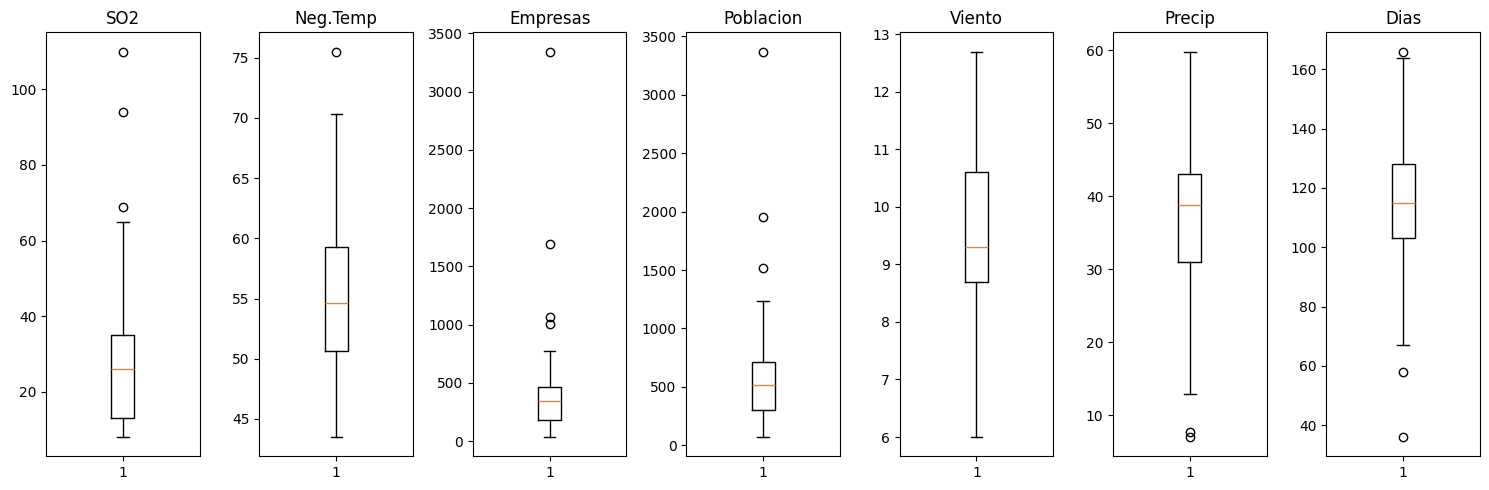

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

for i, columna in enumerate(df.columns):
    axs[i].boxplot(df[columna])
    axs[i].set_title(columna)

plt.tight_layout()

plt.show()

Calculamos las fronteras a partir de las cuales categorizamos outliers utilizando el "método de los bigotes" 

In [79]:
import pandas as pd

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

IQR = Q3 - Q1
outliers_range = 1.5 * IQR

lower_bound = Q1 - outliers_range
upper_bound = Q3 + outliers_range

outlier_bounds = pd.DataFrame({'Lower Bound': lower_bound, 'Upper Bound': upper_bound})

outlier_bounds

,Lower Bound,Upper Bound
SO2,-20.000,68.000
Neg.Temp,37.550,72.350
Empresas,-240.500,883.500
Poblacion,-328.000,1344.000
Viento,5.850,13.450
Precip,12.735,61.335
Dias,65.500,165.500


In [80]:
outliers = (df < lower_bound) | (df > upper_bound)

outliers['cantidad_outliers'] = outliers.sum(axis=1)
outliers = outliers.sort_values(by='cantidad_outliers', ascending=False)

outliers.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias,cantidad_outliers
Ciudad,,,,,,,,
Philadelphia,True,False,True,True,False,False,False,3
Chicago,True,False,True,True,False,False,False,3
Phoenix,False,False,False,False,False,True,True,2
Detroit,False,False,True,True,False,False,False,2
Alburquerque,False,False,False,False,False,True,True,2


Podemos ver las primeras filas del dataframe original ordenadas de manera descendente en función del número de outliers que tiene una ciudad en las distintas variables

In [81]:
df.reindex(outliers.index).head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Philadelphia,69.0,54.6,1692.0,1950.0,9.6,39.93,115.0
Chicago,110.0,50.6,3344.0,3369.0,10.4,34.44,122.0
Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
Detroit,35.0,49.9,1064.0,1513.0,10.1,30.96,129.0
Alburquerque,11.0,56.8,46.0,244.0,8.9,7.77,58.0


### 1.- (1 punto) Estandarizar los datos 

Estandarizamos el dataframe, para pasar todas las variables al mismo rango, para ello nos serviremos de un objeto scaler obtenido de sklearn.preprocessing.StandardScaler\
Los nuevos datos estandarizados se meten en un nuevo pandas.DataFrame

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_std = scaler.fit_transform(df)

df_std = pd.DataFrame(df_std, columns=df.columns, index=df.index)
df_std.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Phoenix,-0.864758,2.036213,-0.449363,-0.046520,-2.440555,-2.556012,-2.975514
Little Rock,-0.735360,0.733515,-0.668567,-0.833224,-0.881504,1.010653,-0.531009
San Francisco,-0.778493,0.131192,-0.018143,0.187743,-0.527174,-1.385471,-1.791457
Denver,-0.562829,-0.541168,-0.016346,-0.163651,-0.314576,-2.048577,-1.065744
Hartford,1.119347,-0.933378,-0.091810,-0.787770,-0.314576,0.567723,0.500266


Generamos estadísticas con .describe().\
(Para que se muestren resultados con 2 decimales se usa un context manager que cambia la configuración del display y una vez se termina el bloque with devuelve a la configuración inicial)

In [83]:
class Notation2Decimal:
    def __enter__(self):
        self.original_config = pd.get_option('display.float_format')
        pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    def __exit__(self, exc_type, exc_value, traceback):
        pd.set_option('display.float_format', self.original_config)

with Notation2Decimal():
    print(df_std.describe().drop('count').T)

           mean  std   min   25%   50%   75%  max
SO2        0.00 1.01 -0.95 -0.74 -0.17  0.21 3.45
Neg.Temp   0.00 1.01 -1.72 -0.72 -0.16  0.50 2.76
Empresas  -0.00 1.01 -0.77 -0.51 -0.21 -0.00 5.18
Poblacion -0.00 1.01 -0.94 -0.54 -0.16  0.19 4.83
Viento     0.00 1.01 -2.44 -0.53 -0.10  0.82 2.31
Precip     0.00 1.01 -2.56 -0.50  0.17  0.55 1.98
Dias      -0.00 1.01 -2.98 -0.42  0.04  0.54 1.99


Vemos que las variables se encuentran en un rango con media 0 y desviación típica 1.\
(No son exactos por problemas de redondeo)

### 2.- (1 punto) Obtención de autovalores y autovectores

In [84]:
df_std.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Phoenix,-0.864758,2.036213,-0.449363,-0.046520,-2.440555,-2.556012,-2.975514
Little Rock,-0.735360,0.733515,-0.668567,-0.833224,-0.881504,1.010653,-0.531009
San Francisco,-0.778493,0.131192,-0.018143,0.187743,-0.527174,-1.385471,-1.791457
Denver,-0.562829,-0.541168,-0.016346,-0.163651,-0.314576,-2.048577,-1.065744
Hartford,1.119347,-0.933378,-0.091810,-0.787770,-0.314576,0.567723,0.500266


Sobre el dataframe estandarizado (df_std) obtenemos la matriz de correlación (df_corr)

In [85]:
df_corr = df_std.corr()
df_corr

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
SO2,1.000000,-0.433600,0.644769,0.493780,0.094690,0.054294,0.369564
Neg.Temp,-0.433600,1.000000,-0.190042,-0.062678,-0.349740,0.386253,-0.430242
Empresas,0.644769,-0.190042,1.000000,0.955269,0.237947,-0.032417,0.131829
Poblacion,0.493780,-0.062678,0.955269,1.000000,0.212644,-0.026119,0.042083
Viento,0.094690,-0.349740,0.237947,0.212644,1.000000,-0.012994,0.164106
Precip,0.054294,0.386253,-0.032417,-0.026119,-0.012994,1.000000,0.496097
Dias,0.369564,-0.430242,0.131829,0.042083,0.164106,0.496097,1.000000


Usando la librería seaborn podemos con una línea de código mostrar las correlaciones de manera gráfica

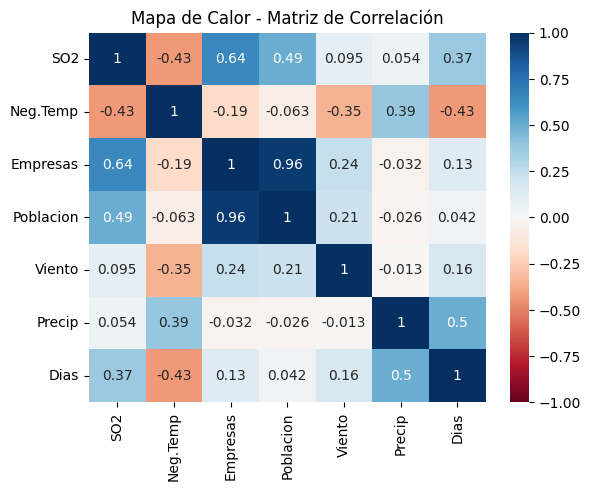

In [86]:
import seaborn as sns
sns.heatmap(df_corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.title('Mapa de Calor - Matriz de Correlación')
plt.show()

Para obtener los autovalores y autovectores utilizamos linalg.eig de numpy, una vez obtenidos los reordenamos de mayor a menor:

In [87]:
eigenvalues, eigenvectors = np.linalg.eig(df_corr.values)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
eigenvalues

array([2.72811968, 1.51233485, 1.39497299, 0.89199129, 0.34677866,
       0.10028759, 0.02551493])

Calculamos la varianza explicada (y su acumulación) por cada una de las nuevas componentes y lo mostramos en un dataframe

In [88]:
variance_perc = (eigenvalues * 100 / np.sum(eigenvalues))
acc_variance_perc = np.cumsum(variance_perc)
comp_index = pd.Index((f'PC{i+1}' for i in range(len(eigenvalues))), name='Componentes')

df_variance = pd.DataFrame({
    'Autovalor': eigenvalues,
    'Varianza explicada(%)': variance_perc,
    'Varianza acumulada(%)': acc_variance_perc},
    index=comp_index)

with Notation2Decimal():
    print(df_variance)

             Autovalor  Varianza explicada(%)  Varianza acumulada(%)
Componentes                                                         
PC1               2.73                  38.97                  38.97
PC2               1.51                  21.60                  60.58
PC3               1.39                  19.93                  80.51
PC4               0.89                  12.74                  93.25
PC5               0.35                   4.95                  98.20
PC6               0.10                   1.43                  99.64
PC7               0.03                   0.36                 100.00


Gráficamente se entiende de manera más intuitiva:

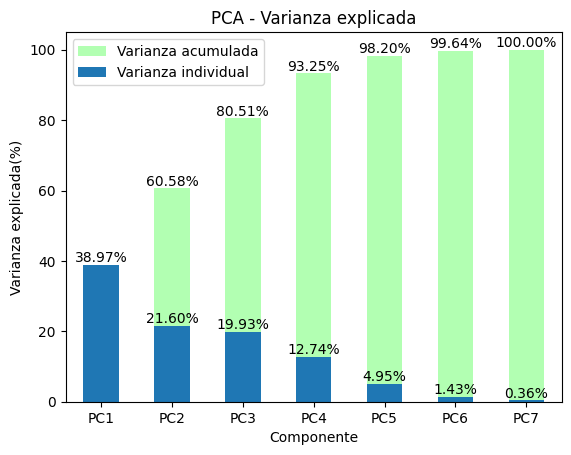

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

x = df_variance.index
y = df_variance.loc[:, 'Varianza explicada(%)']
y_cum = df_variance.loc[:, 'Varianza acumulada(%)']

ax = y_cum.plot(kind='bar', color='lime', alpha=0.3)
for i, valor in enumerate(y_cum):
    plt.text(i, valor, f'{valor:.2f}%', ha='center', va='bottom')

ax = y.plot(kind='bar')
for i, valor in enumerate(y):
    # Acumulada[0] == Individual[0] omit first Acumulada
    if i:
        plt.text(i, valor, f'{valor:.2f}%', ha='center', va='bottom')

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.xlabel('Componente')
plt.ylabel('Varianza explicada(%)')
plt.title('PCA - Varianza explicada')
plt.legend(['Varianza acumulada', 'Varianza individual'], loc='best')
plt.show()

¿Cuánta información perdemos con 2 componentes?

In [90]:
num_comp = 2
info_loss = 100-df_variance.loc[f"PC{num_comp}", "Varianza acumulada(%)"]
print(f'Con {num_comp} componentes perdemos un {info_loss:.2f}%')

Con 2 componentes perdemos un 39.42%


¿Cuánta información representamos con 3 componentes?

In [91]:
num_comp = 3
info = df_variance.loc[f"PC{num_comp}", "Varianza acumulada(%)"]
print(f'Con {num_comp} componentes representamos un {info:.2f}%')

Con 3 componentes representamos un 80.51%


##### 3.- (1 punto)Obtén un diagrama de dispersión en 3 dimensiones y comenta qué has interpretado en él. Elige al menos 4 ciudades de forma aleatoria y explica qué pasa con ellas.

En coordenadas de las 3 primeras componentes principales los datos quedan como sigue:

In [92]:
num_comp = 3
comp_index = pd.Index(f'PC{i+1}' for i in range(num_comp))

df_pca = pd.DataFrame(
    data=np.dot(df_std, eigenvectors[:, :num_comp]),
    columns=comp_index,
    index=df_std.index)

with Notation2Decimal():
    print(df_pca.head())

                PC1   PC2   PC3
Ciudad                         
Phoenix       -2.72 -3.89 -1.06
Little Rock   -1.72  0.48 -0.85
San Francisco -0.94 -2.24  0.18
Denver        -0.55 -1.97  1.23
Hartford       0.46  1.10  0.59


Si elegimos 3 componentes principales los 3 autovectores asociados nos dan información sobre las variables iniciales

In [93]:
num_comp = 3
comp_index = pd.Index(f'PC{i+1}' for i in range(num_comp))

df_3eig = pd.DataFrame(data=eigenvectors[:, :num_comp], index=df_std.columns, columns=comp_index)
with Notation2Decimal():
    print(df_3eig)

            PC1   PC2   PC3
SO2        0.49  0.08 -0.01
Neg.Temp  -0.32 -0.09 -0.68
Empresas   0.54 -0.23 -0.27
Poblacion  0.49 -0.28 -0.34
Viento     0.25  0.06  0.31
Precip     0.00  0.63 -0.49
Dias       0.26  0.68  0.11


Podemos representar las componentes principales contra sí mismas, en 2 dimensiones

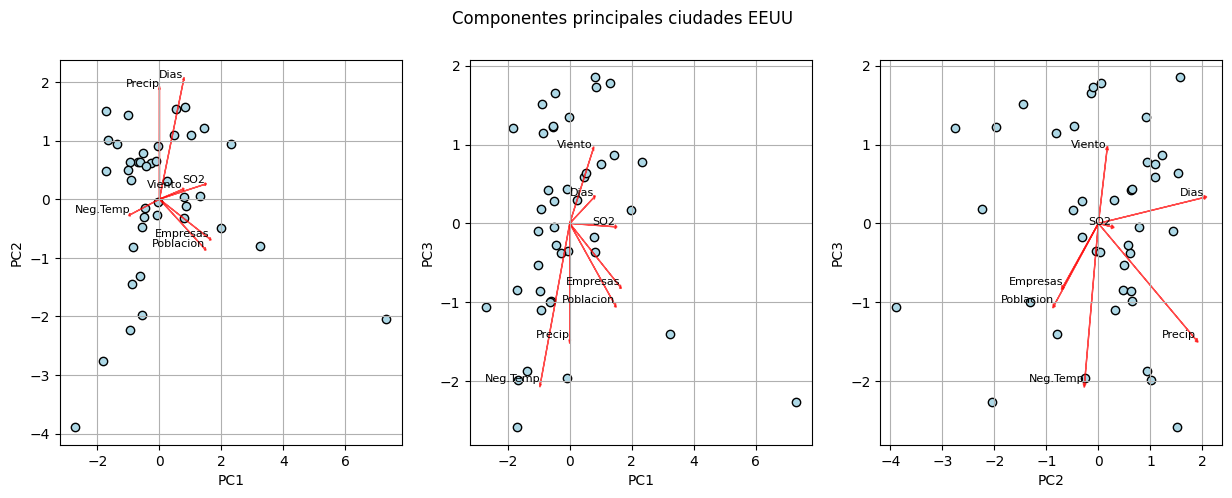

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
num_comp = 3
scale_factor = 3
pc_eigenvectors = eigenvectors[:, :num_comp] * scale_factor
pc_axs = {'PC1': 0, 'PC2': 1, 'PC3': 2}
for i, (x, y) in enumerate([('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]):
    axs[i].scatter(df_pca[x], df_pca[y], color='lightblue', edgecolors='black')
    for j, variable in enumerate(df_std.columns):
        # Components of the eigenvector (same as coords of initial variables) in pc_axs[x], pc_axs[y] dimensions
        u, v = pc_eigenvectors[j, pc_axs[x]], pc_eigenvectors[j, pc_axs[y]]
        axs[i].arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05, head_length=0.05)
        axs[i].text(u, v, variable, color='k', ha='right', va='bottom', fontsize=8)
        axs[i].set_xlabel(x)
        axs[i].set_ylabel(y)
    axs[i].grid()
plt.suptitle('Componentes principales ciudades EEUU')
plt.show()

En 3 dimensiones queda:

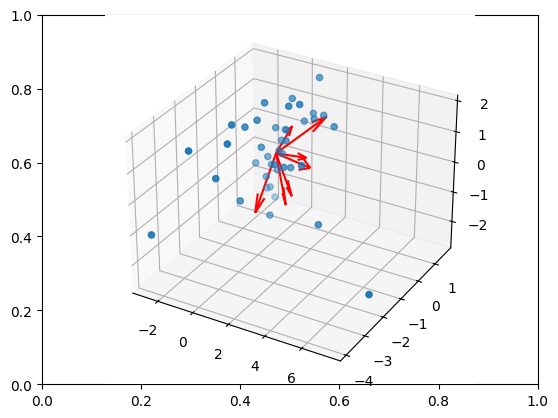

In [95]:
fig, ax = plt.subplots()
ax = plt.subplot(projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'])
for i, variable in enumerate(df_std.columns):
    x, y, z = np.zeros(3)
    u, v, w = eigenvectors[i, :3] * 3
    plt.quiver(x, y, z, u, v, w, color='r')

Veamos 4 ciudades elegidas aleatoriamente.\
Se utiliza el método sample pasando como argumentos el número de ciudades y una seed para poder reproducir los resultados en cualquier máquina.\
Se obtienen dos nuevos dataframes con las ciudades aleatorias escritas en función de las variables iniciales y en función de las componentes principales obtenidas

In [96]:
seed = 40
num_ciudades = 4
city_sample = df.sample(n=num_ciudades, random_state=seed)
city_sample_pca = df_pca.loc[city_sample.index, :]
city_sample

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Cincinnati,23.0,54.0,462.0,453.0,7.1,39.04,132.0
Alburquerque,11.0,56.8,46.0,244.0,8.9,7.77,58.0
Buffalo,11.0,47.1,391.0,463.0,12.4,36.11,166.0
Pittsburgh,61.0,50.4,347.0,520.0,9.4,36.22,147.0


In [97]:
city_sample_pca

,PC1,PC2,PC3
Ciudad,,,
Cincinnati,-0.439862,0.572089,-0.271419
Alburquerque,-1.816821,-2.763310,1.206725
Buffalo,0.827309,1.568931,1.853903
Pittsburgh,1.023394,1.096094,0.750786


Mostramos las ciudades para extraer conclusiones:

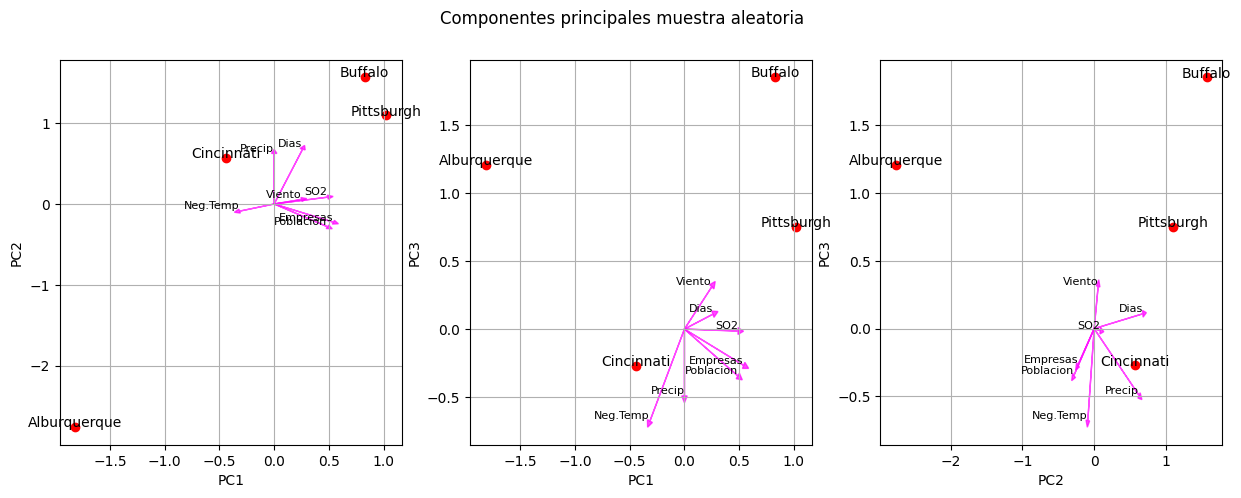

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
num_comp = 3
scale_factor = 1
pc_eigenvectors = eigenvectors[:, :num_comp] * scale_factor
pc_axs = {'PC1': 0, 'PC2': 1, 'PC3': 2}
for i, (x, y) in enumerate([('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]):
    axs[i].scatter(city_sample_pca[x], city_sample_pca[y], color='red')
    for j, row in city_sample_pca.iterrows():
        axs[i].text(row[x], row[y], j, ha='center')
    for j, variable in enumerate(city_sample.columns):
        # Components of the eigenvector (same as coords of initial variables) in pc_axs[x], pc_axs[y] dimensions
        u, v = pc_eigenvectors[j, pc_axs[x]], pc_eigenvectors[j, pc_axs[y]]
        axs[i].arrow(0, 0, u, v, color='magenta', alpha=0.7, head_width=0.05, head_length=0.05)
        axs[i].text(u, v, variable, color='k', ha='right', va='bottom', fontsize=8)
        axs[i].set_xlabel(x)
        axs[i].set_ylabel(y)
    axs[i].grid()
plt.suptitle('Componentes principales muestra aleatoria')
plt.show()

In [99]:
with Notation2Decimal():
    print(df_3eig)

            PC1   PC2   PC3
SO2        0.49  0.08 -0.01
Neg.Temp  -0.32 -0.09 -0.68
Empresas   0.54 -0.23 -0.27
Poblacion  0.49 -0.28 -0.34
Viento     0.25  0.06  0.31
Precip     0.00  0.63 -0.49
Dias       0.26  0.68  0.11


In [100]:
df.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
SO2,30.048780,23.472272,8.00,13.00,26.00,35.00,110.0
Neg.Temp,55.763415,7.227716,43.50,50.60,54.60,59.30,75.5
Empresas,463.097561,563.473948,35.00,181.00,347.00,462.00,3344.0
Poblacion,608.609756,579.113023,71.00,299.00,515.00,717.00,3369.0
Viento,9.443902,1.428644,6.00,8.70,9.30,10.60,12.7
Precip,36.769024,11.771550,7.05,30.96,38.74,43.11,59.8
Dias,113.902439,26.506419,36.00,103.00,115.00,128.00,166.0


Analicemos si el modelo aplicado a estas 4 ciudades elegidas de manera aleatoria es coherente.  
- PC1:
    - Alburquerque tiene componente 1 negativa de mayor magnitud (valor absoluto) esto debería indicarnos que se trata de una ciudad con bajos niveles de SO2, Empresas y Poblacion (relación inversa). Atendiendo a la tabla .describe inicial de este notebook vemos que los valores de Alburquerque para estos campos son 11, 46 y 244 valores que se encuentran muy por debajo de la media (30, 463, 608) más concretamente en el primer cuartil de sus variables correspondientes.
    - En contra parte, de menor magnitud (valor absoluto) pero con valor positivo mayor de las 4 está Pittsburgh, ciudad con valores de SO2, Empresas y Poblacion (61, 347, 520) por encima de la media en SO2 y Poblacion aunque no en número de empresas lo cual se explica por haber tomado la decisión de incluir ciudades significativamente más grandes como ya vimos.
- PC2:
    - De nuevo Alburquerque tiene componente 2 negativa de mayor magnitud, lo cual debería indicarnos valores menores de lo habitual en las variables precipitaciones y días lluviosos, la ciudad toma valores (7.77, 58) los cuales se encuentran  por debajo de la media (36.77, 114).
    - Por otro lado, Buffalo destaca por ser la ciudad con mayor componente 2 positiva de las 4, las precipitaciones y número de días lluvioso es (36, 166) en este caso las precipitaciones se situan en la media y su alta componente 2 se explica por su alto número de días lluviosos valor de la variable ubicada en el cuartil 4.
- PC3:
    - Con mayor componente 3 positiva a la vez que mayor magnitud está Buffalo, lo cual explica valores bajos en la variable Neg.Temp (relación inversa), es decir, debería tener una temperatura baja en comparación con el resto de ciudades y por otro lado aunque se explica en menor medida debería tener bajas precipitaciones por de nuevo tratarse de una relación inversa. Toma valores Neg.Temp y Precipitaciones (47, 36), contrastando con la media (55, 36) vemos que está por debajo de la media con valores de las variables localizados en el segundo cuartil en ambos casos.
Finalmente la ciudad que aún no hemos mencionado, Cincinatti, atendiendo a sus valores de las componentes principales son cercanos a cero, podemos decir que presenta valores que se encuentran en lo que cabría esperar de la ciudad de Estados Unidos media. Por ejemplo, su temperatura 54º es cercana a la media de la población (55º).

Adicional: sklearn dispone del objeto PCA que consigue lo que hemos ido haciendo paso a paso

In [101]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_std)

variance_perc = pca.explained_variance_ratio_ * 100
acc_variance_perc = variance_perc.cumsum()
comp_index = pd.Index([f'PC{i+1}' for i in range(len(eigenvalues))], name='Componentes')

df_variance = pd.DataFrame({    
    'Autovalor': eigenvalues,
    'Varianza explicada(%)': variance_perc,
    'Varianza Acumulada(%)': acc_variance_perc},
    index=comp_index)

with Notation2Decimal():
    print(df_variance)

             Autovalor  Varianza explicada(%)  Varianza Acumulada(%)
Componentes                                                         
PC1               2.73                  38.97                  38.97
PC2               1.51                  21.60                  60.58
PC3               1.39                  19.93                  80.51
PC4               0.89                  12.74                  93.25
PC5               0.35                   4.95                  98.20
PC6               0.10                   1.43                  99.64
PC7               0.03                   0.36                 100.00
